<div style="text-align:center"><span style="color:black; font-family:Times New Roman; font-size:3em;"> Long-term stock prediction </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Introduction </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;padding-left:3em;padding-right:3em;"> Stock prices direction prediction is of enormous use and interest for better trading strategy and decision-making by investors.  However, modeling and predicting of tomorrow’s price direction, based on the financial and stock information of a company, shows lower predictive accuracy in my previous project. 
Benjamin Graham – the father of security analysis – mentioned that in the short run, the market is a voting machine but in the long run, it is a weighing machine. Short-term stock price can change dramatically due to the environment while the underlying value of a company doesn't change. People could buy/sell some stock based on a number of factors that are not relevant to the values of the company. But over long periods of time, actual underlying business performance of a company can play an important key on its market price. 


<br \>
<br \>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this project, I used a Support Vector Regression (SVR) with RBF kernel to (1) predict whether a given stock’s price on day t + m  is higher or lower on day t, and (2) predict stock price on day t + m by using the information on day t. m is 20 business days. A hybrid analysis involving both Fundamental and Technical Analysis was used to provide input variables in order to learn the underlying patterns in the stock time series, and then Principal components analysis (PCA) was applied to extract most important variables. I concluded that in the long-term, significant prediction accuracy can be achieved, compared with the short-term prediction. 
 </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Data Collection and Processing </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The stock market data used in this project is collected from the Sharadar Core Fundamentals database, SF1, in Quandl and Yahoo Finance. For the technical features, I choose daily adjusted open, high, low, close stock price and volume data, the S&P 500 and NASDAQ index, n-days moving average, Exponentially Weighted Moving Average (EWMA), annualized historical volatility, relative strength index, Commodity Channel Index as well as Commodity Channel Index. I also retrieve quarterly fundamental indicators of a company, as shown below. In total I selecte 99 features.  
 
 </span></div>

In [26]:
import quandl
import pandas as pd
import numpy as np
from stockstats import StockDataFrame
import pandas_datareader.data as web
import warnings
warnings.filterwarnings("ignore")

def SF1_List (company_ticker):
    sqllist=['SF1/{}_ASSETS_ARQ'.format(company_ticker),    # Total Assets                           
         'SF1/{}_REVENUE_ARQ'.format(company_ticker),       # Revenue                                      
         'SF1/{}_CAPEX_ARQ'.format(company_ticker),         # Capital Expenditure                     
         'SF1/{}_EQUITY_ARQ'.format(company_ticker),        # Shareholders Equity                     
         'SF1/{}_GP_ARQ'.format(company_ticker),            # Gross Profit                               
         'SF1/{}_EPS_ARQ'.format(company_ticker),           # Earnings per Basic Share         
         'SF1/{}_EBIT_ARQ'.format(company_ticker),          # Earning Before Interest & Taxes (EBIT)
         'SF1/{}_EBITDA_ARQ'.format(company_ticker),        # Earnings Before Interest, Taxes & Depreciation Amortization             
         'SF1/{}_NCFO_ARQ'.format(company_ticker),          # Net Cash Flow from Operations  
         'SF1/{}_LIABILITIES_ARQ'.format(company_ticker),   # Total Liabilities
         'SF1/{}_PB_ARQ'.format(company_ticker),            # Price to Book Value (Price to book value (P/B) ratio)
         'SF1/{}_SHARESWA_ARQ'.format(company_ticker),      # Shares Outstanding (Weighted Average Shares)  
         'SF1/{}_LIABILITIESC_ARQ'.format(company_ticker),  # Current Liabilities
         'SF1/{}_ASSETSC_ARQ'.format(company_ticker),       # Current Assets
         'SF1/{}_INVENTORY_ARQ'.format(company_ticker),     # Inventory 
         'SF1/{}_CURRENTRATIO_ARQ'.format(company_ticker),  # Current Ratio #Current Assets/Current Liabilities
         'SF1/{}_DE_ARQ'.format(company_ticker),            # Debt to Equity Ratio #Total Liabilities/ Shareholders Equity
         'SF1/{}_BVPS_ARQ'.format(company_ticker),          # Book Value per Share #(Stockholders' Equity - Preferred Stock)/ Average shares outstanding                      
         'SF1/{}_NETINC_ARQ'.format(company_ticker),        # Net Income
            ]   
    return sqllist

#######################################################################################################
def get_fundamantal_data(ticker, startdate):
    quandl.ApiConfig.api_key = 'LqAzd9wm8ZWXxLDNtc_1'
    fundamental_data=quandl.get(SF1_List(ticker),start_date= startdate)
    new_columnnames=['Total Assets','REVENUE','Capital Expenditure','Shareholders Equity','Gross Profit',\
                'Earnings per Basic Share','Earning Before Interest and Taxes','EBITDA',\
                'Net Cash Flow from Operation','Total Liabilities',\
                'Price to Book Value', 'Shares Outstanding',\
                'Current Liabilities','Current Assets','Inventory',\
                'Current Ratio','Debt to Equity Ratio','Book Value per Share','Net Income']
    old_columnnames=list(fundamental_data.columns)
    fundamental_data.rename(columns=dict(zip(old_columnnames,new_columnnames)),inplace=True)
    fundamental_data.columns=fundamental_data.columns.map(str.title)
    return fundamental_data


#######################################################################################################
def get_technical_data(ticker,fundamental_data, source):

    if source == 'WIKI':
        data=quandl.get('%s/%s' %('WIKI',ticker), start_date= fundamental_data.index[0])
        selectedcol=["Adj. Close",'Adj. Open','Adj. High','Adj. Low', 'Adj. Volume']
        technical_data=data[selectedcol]
    else:
        data=web.get_data_yahoo(ticker, fundamental_data.index[0])
        technical_data=data.copy()
        ratio=data['Adj Close']/data['Close']
        technical_data['Adj. Open']=data['Open']*ratio
        technical_data['Adj. High']=data['High']*ratio
        technical_data['Adj. Low']=data['Low']*ratio
        technical_data=technical_data.rename(columns={'Volume':'Adj. Volume', 'Adj Close': 'Adj. Close' })
        technical_data=technical_data.drop(['Open','High','Low','Close'], axis=1)
    
    technical_data['Dow 30'] = web.get_data_yahoo('^DJI',fundamental_data.index[0])['Adj Close']
    technical_data['S&P 500'] = web.get_data_yahoo('^GSPC',fundamental_data.index[0])['Adj Close']
    technical_data['NASDAQ'] = web.get_data_yahoo('^IXIC',fundamental_data.index[0])['Adj Close']
    technical_data['12_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 240, min_periods=96)
    technical_data['11_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 220, min_periods=88)
    technical_data['10_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 200, min_periods=80)
    technical_data['9_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 180, min_periods=72)
    technical_data['8_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 160, min_periods=64)
    technical_data['7_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 140, min_periods=56)
    technical_data['6_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 120, min_periods=48)
    technical_data['5_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 100, min_periods=40)
    technical_data['4_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 80, min_periods=32)
    technical_data['3_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 60, min_periods=24)
    technical_data['2_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 40, min_periods=16)
    technical_data['1_month moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 20, min_periods=8)
    technical_data['10-days moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 10, min_periods=4)
    technical_data['5-days moving average'] = pd.rolling_mean(technical_data['Adj. Close'], 5, min_periods=2)
    technical_data['1-week Ewma'] = pd.ewma(technical_data['Adj. Close'], span=5, min_periods=2)
    technical_data['2-week Ewma'] = pd.ewma(technical_data['Adj. Close'], span=10, min_periods=4)
    technical_data['1-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=20, min_periods=8)
    technical_data['2-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=40, min_periods=16)
    technical_data['3-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=60, min_periods=24)
    technical_data['4-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=80, min_periods=32)
    technical_data['5-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=100, min_periods=40)
    technical_data['6-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=120, min_periods=48)
    technical_data['7-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=140, min_periods=56)
    technical_data['8-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=160, min_periods=64)
    technical_data['9-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=180, min_periods=72)
    technical_data['10-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=200, min_periods=80)
    technical_data['11-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=220, min_periods=88)
    technical_data['12-month Ewma'] = pd.ewma(technical_data['Adj. Close'], span=240, min_periods=96)
    
    technical_data['1-week annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 5) * (255**0.5)
    technical_data['2-week annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 10) * (255**0.5)
    technical_data['1-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 20) * (255**0.5)
    technical_data['2-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 40) * (255**0.5)
    technical_data['3-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 60) * (255**0.5)
    technical_data['4-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 80) * (255**0.5)
    technical_data['5-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 100) * (255**0.5)
    technical_data['6-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 120) * (255**0.5)
    technical_data['7-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 140) * (255**0.5)
    technical_data['8-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 160) * (255**0.5)
    technical_data['9-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 180) * (255**0.5)
    technical_data['10-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 200) * (255**0.5)
    technical_data['11-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 220) * (255**0.5)
    technical_data['12-month annualized historical volatility'] = pd.rolling_std(technical_data['Adj. Close'].pct_change(), 240) * (255**0.5)
    stock = StockDataFrame.retype(data)
    #RSI is considered overbought when above 70 and oversold when below 30
    technical_data['2-days relative strength index']= stock['rsi_2']
    technical_data['1-week relative strength index']= stock['rsi_5']
    technical_data['2-week relative strength index']= stock['rsi_10']
    technical_data['1-month relative strength index']= stock['rsi_20']
    technical_data['2-month relative strength index']= stock['rsi_40']
    technical_data['3-month relative strength index']= stock['rsi_60']
    technical_data['4-month relative strength index']= stock['rsi_80']
    technical_data['5-month relative strength index']= stock['rsi_100']
    technical_data['6-month relative strength index']= stock['rsi_120']
    technical_data['7-month relative strength index']= stock['rsi_140']
    technical_data['8-month relative strength index']= stock['rsi_160']
    technical_data['9-month relative strength index']= stock['rsi_180']
    technical_data['10-month relative strength index']= stock['rsi_200']
    technical_data['11-month relative strength index']= stock['rsi_220']
    technical_data['12-month relative strength index']= stock['rsi_240']
    technical_data['stochastic oscillator K line']= stock['kdjk']
    technical_data['stochastic oscillator J line']= stock['kdjj']
    #CCI: Commodity Channel Index
    technical_data['2-weak Commodity Channel Index']=stock['cci']
    return technical_data

#######################################################################################################
def get_hybrid_data(technical_data, fundamental_data):
    combined_data=pd.concat([technical_data,fundamental_data], axis=1).fillna(method= 'ffill')
    combined_data.dropna(inplace=True)
    
    #Calculate the price to earnings ratio                   
    combined_data["PE Ratio"]= combined_data['Adj. Close'] / combined_data['Earnings Per Basic Share'] 
    combined_data['Capital Expenditure Coverage'] = combined_data['Net Cash Flow From Operation'] / combined_data['Capital Expenditure']
    combined_data['Free Cash Flow Operating Ratio'] = \
    (combined_data["Net Cash Flow From Operation"] - combined_data["Capital Expenditure"]) / combined_data["Net Cash Flow From Operation"]

    combined_data['Operating Cash Flow Ratio'] = combined_data["Net Cash Flow From Operation"] / combined_data["Revenue"] 
    combined_data['Debt Ratio'] = combined_data["Total Liabilities"] / combined_data["Total Assets"] 
    combined_data['Cash Flow To Debt Ratio'] = combined_data["Net Cash Flow From Operation"] / combined_data["Total Liabilities"] 
    combined_data['Cash Flow Per Share'] = combined_data["Net Cash Flow From Operation"] / combined_data["Shares Outstanding"]
    combined_data['Cash Ratio']  = combined_data["Net Cash Flow From Operation"] / combined_data["Current Liabilities"]
    combined_data['Quick Ratio'] = (combined_data["Current Assets"] - combined_data["Inventory"]) / combined_data["Current Liabilities"]
    combined_data['Gross Profit Margin'] = combined_data["Gross Profit"] / combined_data["Revenue"]

    combined_data['Price To Sales Ratio'] = combined_data['Adj. Close'] / (combined_data["Revenue"] / combined_data["Shares Outstanding"] )
    combined_data['Return On Average Equity']  = combined_data["Net Income"] / combined_data["Shareholders Equity"] 
    combined_data=combined_data.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    return combined_data


<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;">   For illustration purpose, I chose the Apple stock data, starting from 2011-01-05 until the most recent date (2017-04-13). There are 99 features as the input variables which are 68 technical and 31 fundamental features.   

 </span></div>

In [18]:
company='AAPL'
fundamental_data = get_fundamantal_data(company, '2010-01-02')
technical_data = get_technical_data(company,fundamental_data, 'yahoo')
combined_data = get_hybrid_data(technical_data, fundamental_data)

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  Total data number </span></div>

In [40]:
len(combined_data)

1579

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;">  Technical input variables </span></div>

In [10]:
list(combined_data.columns)[:68]

['Adj. Volume',
 'Adj. Close',
 'Adj. Open',
 'Adj. High',
 'Adj. Low',
 'Dow 30',
 'S&P 500',
 'NASDAQ',
 '12_month moving average',
 '11_month moving average',
 '10_month moving average',
 '9_month moving average',
 '8_month moving average',
 '7_month moving average',
 '6_month moving average',
 '5_month moving average',
 '4_month moving average',
 '3_month moving average',
 '2_month moving average',
 '1_month moving average',
 '10-days moving average',
 '5-days moving average',
 '1-week Ewma',
 '2-week Ewma',
 '1-month Ewma',
 '2-month Ewma',
 '3-month Ewma',
 '4-month Ewma',
 '5-month Ewma',
 '6-month Ewma',
 '7-month Ewma',
 '8-month Ewma',
 '9-month Ewma',
 '10-month Ewma',
 '11-month Ewma',
 '12-month Ewma',
 '1-week annualized historical volatility',
 '2-week annualized historical volatility',
 '1-month annualized historical volatility',
 '2-month annualized historical volatility',
 '3-month annualized historical volatility',
 '4-month annualized historical volatility',
 '5-mon

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;"> Fundamental input variables </span></div>

In [11]:
list(combined_data.columns)[68:]

['Total Assets',
 'Revenue',
 'Capital Expenditure',
 'Shareholders Equity',
 'Gross Profit',
 'Earnings Per Basic Share',
 'Earning Before Interest And Taxes',
 'Ebitda',
 'Net Cash Flow From Operation',
 'Total Liabilities',
 'Price To Book Value',
 'Shares Outstanding',
 'Current Liabilities',
 'Current Assets',
 'Inventory',
 'Current Ratio',
 'Debt To Equity Ratio',
 'Book Value Per Share',
 'Net Income',
 'PE Ratio',
 'Capital Expenditure Coverage',
 'Free Cash Flow Operating Ratio',
 'Operating Cash Flow Ratio',
 'Debt Ratio',
 'Cash Flow To Debt Ratio',
 'Cash Flow Per Share',
 'Cash Ratio',
 'Quick Ratio',
 'Gross Profit Margin',
 'Price To Sales Ratio',
 'Return On Average Equity']

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  The technical and fundamental variables in the combined_data dataframe are the feature input variables X. The feature set of a stock on the day t is used to predict the stock price on the day t + m, where m is 20 business days (4 weeks).  The predicted output Y on day t is the adjusted closing price difference between the day t and day t + m. I am solving a regression problem. Therefore, I shift the 'Adj. Close' (Adjusted closing price) column of the combined_data dataframe backwards 20 days and substrate it by the 'Adj. Close' value on the current day.
<br \>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Because the target variable is the closing price on the day t + m subtracted by the price on the day t, the last m days in the target variable will be ‘NULL’. Therefore I drop the data on the last m days in both the feature variables and target variable.

 </span></div>

In [22]:
def generate_XY_variables(combined_data, i):
    X=combined_data[:-i]
    Y_regre= combined_data['Adj. Close'].shift(-i) - combined_data['Adj. Close']
    Y=Y_regre[:-i] 
    return X, Y

In [23]:
window=20
X, Y = generate_XY_variables(combined_data, window)

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I split the feature variables X and the target output Y into the training and test sets by selecting a split point.  The training dataset is used to train a Machine Learning Model, while the test dataset is to evaluate prediction results. This method of Train-Test split maintains temporal order of data observations. For time series data, we cannot assume that there is no relationship between the observations. Hence, I don’t shuffle data randomly, because I may lose its nature order of data. I select the last 60 business days as the test set for model evaluation and the rest of data as the training set. I call them as x_train, x_test, y_train, y_test.
<br \>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before performing Principal Component Analysis (PCA) on the feature extraction, data normalization procedure is crucial because PCA tries to analyze the variance in the set of feature variables.  PCA requires that the input variables have similar scales of measurement. Therefore, I standardize the features by using Z-score normalization so that all features are centered around 0 with a standard deviation of 1. 






 </span></div>

In [28]:
def train_test_split_scale(X, Y, window):
    number_testfolds=3
    test_start=window*number_testfolds
    x_train = X[:-test_start]
    y_train = Y[:-test_start]
    x_test = X[-test_start:]
    y_test = Y[-test_start:]
    scaler=StandardScaler()
    x_train_std=scaler.fit_transform(x_train)
    x_test_std=scaler.transform(x_test)
    return x_train, y_train, x_test, y_test, x_train_std, x_test_std
    

In [29]:
x_train, y_train, x_test, y_test, x_train_std, x_test_std=train_test_split_scale(X, Y, window)

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Feature extraction  /Model training </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Principal components analysis (PCA) is very powerful for feature extraction. PCA can convert a set of
possibly correlated feature variables into a set of linearly uncorrelated variables called as principal components, such that most of the variability of the data information is still maintained. PCA is able to capture the most variable data components of samples. One of the PCA parameters is n_components which is the number of the principle components to keep. 
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The feature components extracted by PCA is fed into a Support Vector Regression (SVR) model. The SVR model is based on a support vector machine (SVM). The SVR is famous for its robustness and insensitivity on outliers. The basic idea is to map the input data into a high dimensional feature space by using non-linear mapping function and then a linear regression problem is solved in the new feature space. In this project, I used Radial Basis Function (kernel) as the mapping function. 
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  In order to optimize the PCA and SVR parameters, the training set is further divided into the train set and validation set. I used the last 50% of training set as the validation set which is split into n consecutive time folds. The time window of each fold is 20 business days. The validation set is iterated over the consecutive time folds to test and evaluate the SVR model.  In the beginning, the first 50% of training set is used as the train set to train the model. 
<br/>
For each iteration in the validation set which consists of n consecutive folds:
<br/>
(1)	The SVR model is trained by the train set 
<br/>
(2)	The prediction made by the model is performed on the i-th fold of the validation set and will be stored for later evaluation. 
<br/>
(3)	The feature variables and the actual target values from the i-th fold of the validation set will be added to the
train set for the next iteration. 
<br/>
In the end, the predictions made during the iteration of the validation set will be evaluated in terms of mean absolute error (MAE). The mean absolute error is an average of the absolute errors between the prediction and the true value.

<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To select the best optimized parameters for SVR and to verify the model, I perform grid search the combinations of the n_component parameter of the PCA and the regularization constant 
C and epsilon value of the SVR model in order to find the optimized combination that results in the best performance on the validation set. The best combination of the PCA and SVR parameters will be the one with the smallest MAE in the validation set.  


 </span></div>

In [31]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [32]:
def model_SVR(x_train_std, xtrain, xvalidation, ytrain, yvalidation, c, epsi,window):
    xhistory=xtrain.copy()
    yhistory=ytrain.copy()
    predictions = []
    end=((int(len(x_train_std) * 0.50)/window)-1)*window+1
    for i in range(0,end,window): 
        lr = SVR(C=c, epsilon=epsi)
        lr = lr.fit(xhistory, yhistory)       
        y_pred=lr.predict(xvalidation[i:window+i])
        predictions.append(y_pred)
        xhistory=np.vstack((xhistory,xvalidation[i:window+i]))
        yhistory=np.r_[yhistory, yvalidation[i:window+i]]
        #calculate the metrics for each validation fold
        submae=mean_absolute_error(y_true=yvalidation[i:window+i], y_pred=y_pred)
        subr2=r2_score(y_true=yvalidation[i:window+i], y_pred=y_pred)
        #print 'r2=%.5f' %subr2
        #print 'MAE=%.5f' %submae
        count=0
        for a in range(0, len(yvalidation[i:window+i])):
            if np.sign(yvalidation[i:window+i][a]) == np.sign(y_pred[a]):
                count +=1
        Accuracy = count*100/len(y_pred)
        #print 'Accuracy = %.2f%%' %Accuracy
    y_true=yvalidation 
    y_pred=np.ravel(predictions)
    #calculate the average metrics for the validation set
    r2=r2_score(y_true=y_true, y_pred=y_pred)
    mae=mean_absolute_error(y_true=y_true, y_pred=y_pred)
    #mse=mean_mean_squared_error(y_true=yvalidation, y_pred=np.ravel(predictions))
    #rmsd=np.sqrt(mse)
    #print '{}: {}'.format('R^2 score', r2) 
    #print '{}: {}'.format('Mean absolute error', mae)
    count=0
    for a in range(0, len(yvalidation)):
        if np.sign(yvalidation[a]) == np.sign(np.ravel(predictions)[a]):
            count +=1
    Accuracy = count*100/len(yvalidation)
    #print '{} : {:.3f}'.format('Accuracy(%)', Accuracy)
    return r2, mae, Accuracy, y_pred

In [37]:
def gridsearch(x_train_std, y_train, window, n_range=range(17,20,1), c_range=range(40,80,10), e_range=[0.2] ):
    best_score, best_param = float("inf"), None
    for n in n_range:
        for d in c_range:
            for k in e_range:
                pca = PCA(n_components=n)
                x_train_pca = pca.fit_transform(x_train_std)
                train_size = (int(len(x_train_pca) * 0.50)/window)*window
                xtrain, xvalidation = x_train_pca[0:-train_size], x_train_pca[-train_size:]
                ytrain, yvalidation = y_train.values[0:-train_size], y_train.values[-train_size:]
                order = (n,d,k)
                try:
                    r2_validation, mae_validation, Accuracy_validation, y_pred = \
                    model_SVR(x_train_std, xtrain, xvalidation, ytrain, yvalidation, d, k, window)
                    print 'n=%d, C=%d, epsi=%.1f' %(n,d,k)
                    print 'MAE= %.5f' % (mae_validation)
                    print 'Accuracy= %.5f' % (Accuracy_validation)
                    if mae_validation < best_score:
                        best_score, best_param = mae_validation, order
                        y_train_pred=y_pred
                        best_Accuracy=Accuracy_validation
                        #print 'Accuracy= %.5f' % (Accuracy_validation)
                except:
                    continue
    print('Best parameters (n, C, epsilon)=%s mae=%.3f' % (best_param, best_score))
    return best_param, best_score, best_Accuracy, y_train_pred, yvalidation

In [39]:
best_param, mae_validation, Accuracy_validation, y_train_pred, yvalidation=\
gridsearch(x_train_std, y_train, window, n_range=range(15,20,1), c_range=range(10,80,10), e_range=[0.1,0.2] )

n=15, C=10, epsi=0.1
MAE= 4.83007
Accuracy= 65.00000
Accuracy= 65.00000
n=15, C=10, epsi=0.2
MAE= 4.83942
Accuracy= 65.00000
n=15, C=20, epsi=0.1
MAE= 4.80472
Accuracy= 66.00000
Accuracy= 66.00000
n=15, C=20, epsi=0.2
MAE= 4.81943
Accuracy= 66.00000
n=15, C=30, epsi=0.1
MAE= 4.80657
Accuracy= 66.00000
n=15, C=30, epsi=0.2
MAE= 4.83415
Accuracy= 66.00000
n=15, C=40, epsi=0.1
MAE= 4.81740
Accuracy= 67.00000
n=15, C=40, epsi=0.2
MAE= 4.83302
Accuracy= 66.00000
n=15, C=50, epsi=0.1
MAE= 4.81394
Accuracy= 66.00000
n=15, C=50, epsi=0.2
MAE= 4.81458
Accuracy= 67.00000
n=15, C=60, epsi=0.1
MAE= 4.81209
Accuracy= 66.00000
n=15, C=60, epsi=0.2
MAE= 4.80850
Accuracy= 66.00000
n=15, C=70, epsi=0.1
MAE= 4.81975
Accuracy= 66.00000
n=15, C=70, epsi=0.2
MAE= 4.82413
Accuracy= 66.00000
n=16, C=10, epsi=0.1
MAE= 4.82152
Accuracy= 66.00000
n=16, C=10, epsi=0.2
MAE= 4.83513
Accuracy= 65.00000
n=16, C=20, epsi=0.1
MAE= 4.79776
Accuracy= 67.00000
Accuracy= 67.00000
n=16, C=20, epsi=0.2
MAE= 4.81718
Accuracy

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> The best combination with the smallest MAE is n_components =18, C=50, and epsilon=0.1. 

 </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Model evaluation </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  The performance of the model on ‘unseen’ data is tested in the  test set. The test set is divided into 3 consecutive folds and iterated to test the final model with the best parameter combination. Each fold has the time window of 20 business days. As mention in previous section, I make prediction of the test set in a rolling-forecast manner. For each iteration over the consecutive folds in the test set, the prediction on each fold is performed and then the observation is updated to the history for prediction in the next fold. 
    
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The mean absolute error between the actual values and the prediction for the adjusted closing price difference between the day t and day t + 20 is evaluated. The MAE in the test set is 3.37 while the best MAE in the validation set is 4.75. I also convert the stock price difference between the day t and day t + 20 into a binary output. If the difference is larger than 0, I label it as 1, which means the closing price on the day t + 20 is higher than the current day t. Otherwise, I label it as 0. Accuracy is used to evaluate the proportion of correctly binary outputs between the actual observation and the prediction. The accuracy in the test set that predicts the stock price on the day t + 20 is higher/lower than the price on the day t is 100 %.
 </span></div>

In [35]:
def prediction_test(best_param, x_train_std, x_test_std, y_train, y_test, window):
    pca = PCA(n_components=best_param[0])
    x_train_pca = pca.fit_transform(x_train_std)
    x_test_pca = pca.transform(x_test_std)
    
    xhistory_test=x_train_pca.copy()
    yhistory_test=y_train.copy()
    predictions = []
    end=3*window
    for i in range(0,end,window): 
        lr = SVR(C=best_param[1], epsilon=best_param[2])
        lr = lr.fit(xhistory_test, yhistory_test)       
        y_pred=lr.predict(x_test_pca[i:window+i])
        predictions.append(y_pred)
        xhistory_test=np.vstack((xhistory_test,x_test_pca[i:window+i]))
        yhistory_test=np.r_[yhistory_test, y_test[i:window+i]]
        submae=mean_absolute_error(y_true=y_test[i:window+i], y_pred=y_pred)
        #print 'MAE=%.5f' %submae
        count=0
        for a in range(0, len(y_test[i:window+i])):
            if np.sign(y_test[i:window+i][a]) == np.sign(y_pred[a]):
                count +=1
        Accuracy = count*100/len(y_pred)
        #print 'Accuracy = %.2f%%' %Accuracy
    y_test_pred=np.ravel(predictions)    
    mae_test=mean_absolute_error(y_true=y_test, y_pred=np.ravel(predictions))
    print '{}: {}'.format('Mean absolute error in the test set', mae_test)
    count=0
    for a in range(0, len(y_test)):
        if np.sign(y_test[a]) == np.sign(np.ravel(predictions)[a]):
            count +=1
    Accuracy_test = count*100/len(y_test)
    print '{} : {:.3f}'.format('Accuracy(%) in the test set', Accuracy_test)
    return y_test_pred, mae_test, Accuracy_test

In [41]:
y_test_pred, mae_test, Accuracy_test = prediction_test(best_param, x_train_std, x_test_std, y_train, y_test, window)

Mean absolute error in the test set: 3.36999043845
Accuracy(%) in the test set : 100.000


<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Prediction plots </span></div>

In [42]:
def prediction_plot(y_train_pred, y_validation, combined_data, window, mae_validation,Accuracy_validation, validation, company): 
    y_train_pred=Series(y_train_pred, index=y_validation.index)
    predicted_price_validation=(y_train_pred + combined_data['Adj. Close']).shift(window).dropna()
    real_price_validation=combined_data['Adj. Close'][predicted_price_validation.index[0]:predicted_price_validation.index[-1]]
    baseline_validation=(combined_data['Adj. Close']).shift(window).\
    dropna()[predicted_price_validation.index[0]:predicted_price_validation.index[-1]]

    up_validation=Series(np.where(np.sign(y_train_pred)>0, 1000, 0), index=y_validation.index)
    up_validation=(up_validation + combined_data['Adj. Close']*0).shift(window).dropna()
    down_validation=Series(np.where(np.sign(y_train_pred)<0, 1000, 0), index=y_validation.index)
    down_validation=(down_validation + combined_data['Adj. Close']*0).shift(window).dropna()
    
    ##plot
    fig, (ax1,ax2)=plt.subplots(2,1,figsize=(12,8))
    ax1.plot(predicted_price_validation.index,np.where(predicted_price_validation>0, predicted_price_validation, 0), 
             lw=4, color='blue', ls='--' ,label='Prediction')
    ax1.plot(real_price_validation.index,real_price_validation, label = "Actual price", color='Black', lw=4)
    ax1.minorticks_on()
    ax1.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

    ax1.legend(loc='lower center')
    ax1.set_xlim(predicted_price_validation.index[0],predicted_price_validation.index[-1])   
    ax1.set_ylim(np.min([predicted_price_validation.min(),real_price_validation.min()])*0.9,
                 np.max([predicted_price_validation.max(),real_price_validation.max()])*1.1)

    ax1.text(predicted_price_validation.index[10], (np.max([predicted_price_validation.max(),real_price_validation.max()])*1.05), 
             "Mean absolute error: %.3f " % (mae_validation), fontsize=12) 
    ax1.set_title("%s stock prediction performance in the validation set" % (company) )
    #####################################
    ax2.plot(baseline_validation.index,baseline_validation, color='red', lw=4, label='Base line')
    ax2.plot(real_price_validation.index,real_price_validation, label = "Actual price", color='Black', lw=4)
    ax2.bar(up_validation.index,up_validation, color='lawngreen', edgecolor = "none")
    ax2.bar(down_validation.index,down_validation, color='lightsalmon', edgecolor = "none")
    ax2.minorticks_on()
    ax2.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

    ax2.legend(loc='lower center')
    ax2.set_xlim(real_price_validation.index[0],real_price_validation.index[-1]) 
    ax2.set_ylim(np.min([real_price_validation.min(),baseline_validation.min()])*0.9,
                 np.max([real_price_validation.max(),baseline_validation.max()])*1.1)  
    ax2.text(predicted_price_validation.index[10], (np.max([real_price_validation.max(),baseline_validation.max()])*1.05),
             "Accuracy of Up/Down baseline: %.2f %%" % (Accuracy_validation), fontsize=12) 
    ax1.set_title("%s stock prediction performance in the %s set" % (company, validation) )

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;"> The actual and predicted adjusted closing prices in the validation set : </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The upper figure shows the comparison of the actual and predicted adjusted closing prices in the validation set. The mean absolute error in the validation set is 4.75. The error between the actual and predicted price is about 3 – 4 % of the stock price. 
    
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In the lower figure, the red line signifies the adjusted closing price on the day t – 20. The black line represents the actual price on the day t. A color bar on each day marks the prediction that the adjusted closing price on the day t will be higher (green bar) or lower (pink bar) than the price on the day t - 20. I called the red line as the base line which is the price 4 weeks (20 business days) ago, compared with the current price. A green bar shows the current stock price is predicted to be higher than the base line, while a pink bar predicts the current stock will be lower than the base line. The accuracy that predicts the current price will be higher/lower than the base line in the validation set is about 68 %.

 </span></div>

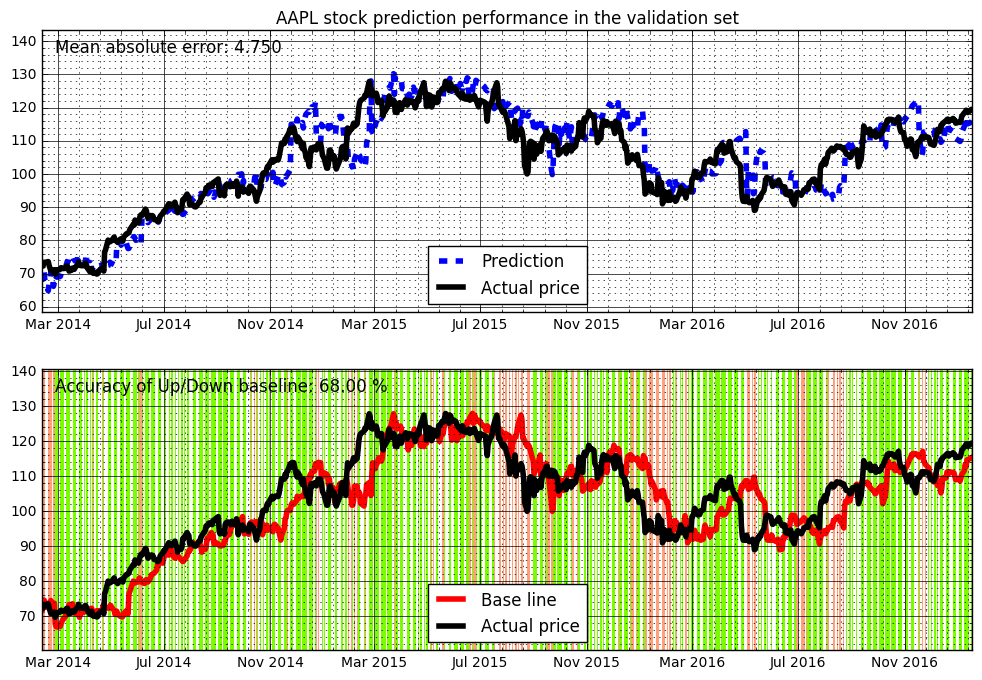

In [44]:
train_size = (int(len(x_train_std) * 0.50)/window)*window
prediction_plot(y_train_pred, y_train[-train_size:], combined_data, window, mae_validation, Accuracy_validation,'validation', company)

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;"> The actual and predicted adjusted closing prices in the test set : </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The time window of the test set is 60 business days (about 3 month). I don’t choose long timespan for the test set because the more the test data is far away from the training set, the more the prediction could be off from the actual price. The upper figure shows the comparison of the actual and predicted adjusted closing prices in the test set. The mean absolute error in the validation set is 3.37. In the lower figure, all green bars on each day show the current price will be higher than the baseline. Indeed, the actual price marked by the black line is above the red line across the entire test set window. The prediction accuracy is 100 %.  
    
 </span></div>

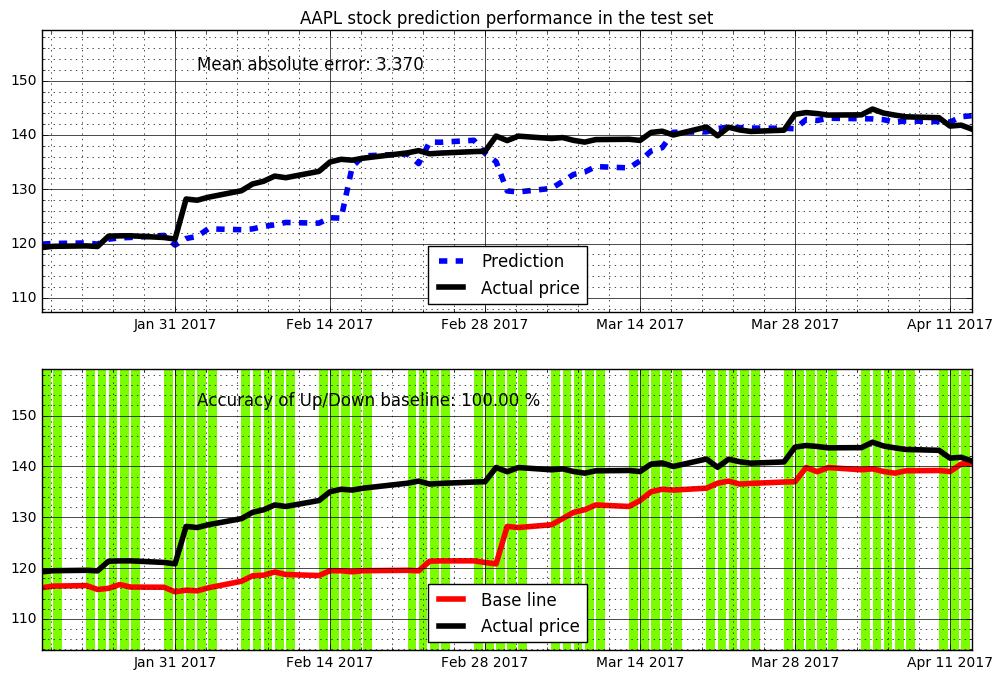

In [45]:
prediction_plot(y_test_pred, y_test, combined_data, window, mae_test,Accuracy_test, 'test', company)

<div style="text-align:left"><span style="color:red; font-family:Times New Roman; font-size:1.5em;"> The confusion matrix in the validation set: </span></div>

In [47]:
def validation_confusion_matrix(yvalidation, y_train_pred):
    y_true=np.where(yvalidation>0, 1, 0)
    y_pred=np.where(y_train_pred>0, 1, 0)
    c=confusion_matrix(y_true, y_pred, labels=[1, 0])
    np.set_printoptions(precision=5)
    c=c.astype('float')/c.sum()

    plt.figure()
    plt.imshow(c, interpolation='nearest',cmap=plt.cm.Blues)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Up', 'Down'])
    plt.yticks(tick_marks, ['Up', 'Down'])
    plt.colorbar()
    thresh = c.max() / 2.

    for i, j in itertools.product(range(c.shape[0]), range(c.shape[1])):
        plt.text(j, i, '%.2f' % c[i, j],horizontalalignment="center",
                 color="white" if c[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix in the validation set')

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; When the stock price difference between the day t and day t + 20 is transformed into binary output, a confusion matrix can be used to describe the performance of predicted classification. The vertical axis represents the actual labels, while the horizontal axis corresponds to the  predicted labels. In the validation set, True Positives (TP) are the cases in which I predict Up (the stock price on the day t + 20 will be higher than the price on the day t), and the stock price is actually higher. True Negatives (TN) are the cases in which I predict Down (the stock price on the day t + 20 will be lower than the price on the day t), and the stock price is actually lower. The accuracy is calculated from TP and TN, which is about 69%. It is worth noting that Misclassification Rate (about 31%) mostly happens in the cases of False Positives (FP). The probability that the stock is predicted to be higher than the baseline but turns out to be lower is about 25%. 
    
 </span></div>

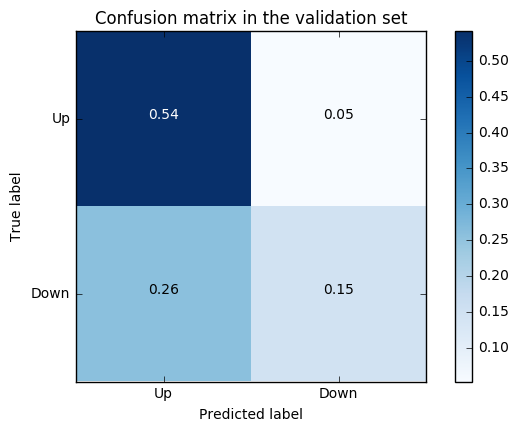

In [49]:
validation_confusion_matrix(yvalidation, y_train_pred)

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Conclusion </span></div>

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; In this project, I have applied a PCA-SVR integrated model to predict the price value and movement direction of Apple stock over the long time (20 business days). For all 99 fundamental and technical input variables, 18 principle components extracted by the PCA are selected to achieve the best performance of the SVR forecasting. 
The PCA-SVR parameters are selected based on a grid search approach and the model is verified using rolling-window cross validation technique, which makes the model performance more robust. The results show that the model provides significantly high accuracy for forecasting movement directions of Apple stock -- about 68 % accuracy in the validation set and 100 % in the test set. The mean absolute error is 4.75 in the validation set and 3.37 in the test set. The uncertainty on the predicted price is about 3-4% of the stock price. 

    
 </span></div>

<div style="text-align:center"><span style="color:blue; font-family:Times New Roman; font-size:3em;"> Future stock prediction  </span></div>

In [50]:
def train_test_split_scale_for_future(X, Y, combined_data, window):
    x_train = X
    y_train = Y
    x_test= combined_data[-window:]
    scaler=StandardScaler()
    x_train_std=scaler.fit_transform(x_train)
    x_test_std=scaler.transform(x_test)
    return x_train, y_train, x_test, x_train_std, x_test_std
    

In [51]:
x_train, y_train, x_test, x_train_std, x_test_std =train_test_split_scale_for_future(X, Y, combined_data, window)

In [52]:
best_param, mae_validation, Accuracy_validation, y_train_pred, yvalidation=\
gridsearch(x_train_std, y_train, window, n_range=range(17,20,1), c_range=range(50,80,10), e_range=[0.2] )

n=17, C=50, epsi=0.2
MAE= 4.84563
Accuracy= 69.00000
Accuracy= 69.00000
n=17, C=60, epsi=0.2
MAE= 4.84896
Accuracy= 69.00000
n=17, C=70, epsi=0.2
MAE= 4.85935
Accuracy= 69.00000
n=18, C=50, epsi=0.2
MAE= 4.81332
Accuracy= 70.00000
Accuracy= 70.00000
n=18, C=60, epsi=0.2
MAE= 4.80562
Accuracy= 70.00000
Accuracy= 70.00000
n=18, C=70, epsi=0.2
MAE= 4.81281
Accuracy= 70.00000
n=19, C=50, epsi=0.2
MAE= 4.82341
Accuracy= 69.00000
n=19, C=60, epsi=0.2
MAE= 4.81106
Accuracy= 70.00000
n=19, C=70, epsi=0.2
MAE= 4.81423
Accuracy= 70.00000
Best parameters (n, C, epsilon)=(18, 60, 0.2) mae=4.806


In [67]:
def prediction_future_plot(x_train_std,x_test_std, y_train,x_test, best_param, holidays, \
                           combined_data,window, mae_validation,Accuracy_validation, company):
    pca = PCA(n_components=best_param[0])
    x_train_pca = pca.fit_transform(x_train_std)
    x_test_pca = pca.transform(x_test_std)

    lr = SVR(C=best_param[1], epsilon=best_param[2])
    lr = lr.fit(x_train_pca, y_train)       
    y_test_pred=lr.predict(x_test_pca)
    
    y_test_pred=Series(y_test_pred, index=x_test.index)
    s=pd.date_range(y_test_pred.index[-1]+pd.offsets.BDay(), periods=window, freq='B')
    s1=y_test_pred.reindex(s)
    predicted_price_test=(y_test_pred + combined_data['Adj. Close']).add(s1, fill_value=0).shift(window).dropna()
    
    baseline_test=combined_data['Adj. Close'].add(s1, fill_value=0).\
    shift(window).dropna()[predicted_price_test.index[0]:predicted_price_test.index[-1]]
    
    previous_day_price=combined_data['Adj. Close'][-1]
    up_test=Series(np.where(np.sign(y_test_pred)>0, 1000, 0), index=x_test.index)
    up_test=(up_test + combined_data['Adj. Close']*0).add(s1, fill_value=0).shift(window).dropna()
    down_test=Series(np.where(np.sign(y_test_pred)<0, 1000, 0), index=x_test.index)
    down_test=(down_test + combined_data['Adj. Close']*0).add(s1, fill_value=0).shift(window).dropna()
    #holidays=['2017-04-14']
    if holidays != []:
        s2=pd.date_range(predicted_price_test[holidays[0]:].index[0]+pd.offsets.BDay(),
                         periods=len(predicted_price_test[holidays[0]:]), freq='B')
        predicted_price_test=pd.concat([predicted_price_test[:holidays[0]][:-1],
                                        Series(predicted_price_test[holidays[0]:].values, index=s2)])
        baseline_test=pd.concat([baseline_test[:holidays[0]][:-1],Series(baseline_test[holidays[0]:].values, index=s2)])
        up_test =pd.concat([up_test[:holidays[0]][:-1],Series(up_test[holidays[0]:].values, index=s2)])
        down_test =pd.concat([down_test[:holidays[0]][:-1],Series(down_test[holidays[0]:].values, index=s2)])
  
    fig, ax=plt.subplots(1,1,figsize=(12,8))
    ax.plot(predicted_price_test.index,np.where(predicted_price_test>0, predicted_price_test, 0), 
            lw=4, color='blue', ls='--' ,label='Prediction')
    ax.plot(baseline_test.index,baseline_test, color='red', lw=4, label='Base line')
    ax.bar(up_test.index,up_test, color='lawngreen', edgecolor = "none")
    ax.bar(down_test.index,down_test, color='lightsalmon', edgecolor = "none")
    ax.hlines(y=previous_day_price, xmin=predicted_price_test.index[0], 
                  xmax=predicted_price_test.index[1], lw=7, 
              color='darkgreen',label='%s price' %combined_data['Adj. Close'].index[-1].strftime('%Y-%m-%d'))

    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

    ax.legend(loc='lower center')
    ax.set_xlim(predicted_price_test.index[0],predicted_price_test.index[-1])   
    ax.set_ylim(np.min([predicted_price_test.min(),baseline_test.min()])*0.9,
                np.max([predicted_price_test.max(),baseline_test.max()])*1.1)
    ax.text(predicted_price_test.index[0], (np.max([predicted_price_test.max(),baseline_test.max()])*1.08), 
            "Mean absolute error in the validation set: %.3f " % (mae_validation), fontsize=12) 
    

    ax.text(predicted_price_test.index[0], (np.max([predicted_price_test.max(),baseline_test.max()])*1.05),
            "Accuracy of Up/Down baseline in the validation set: %.2f %%" % (Accuracy_validation), fontsize=12) 

    ax.set_title("%s stock prediction %s -- %s" % (company, predicted_price_test.index[0].strftime('%Y-%m-%d'), 
                                                   predicted_price_test.index[-1].strftime('%Y-%m-%d') ))

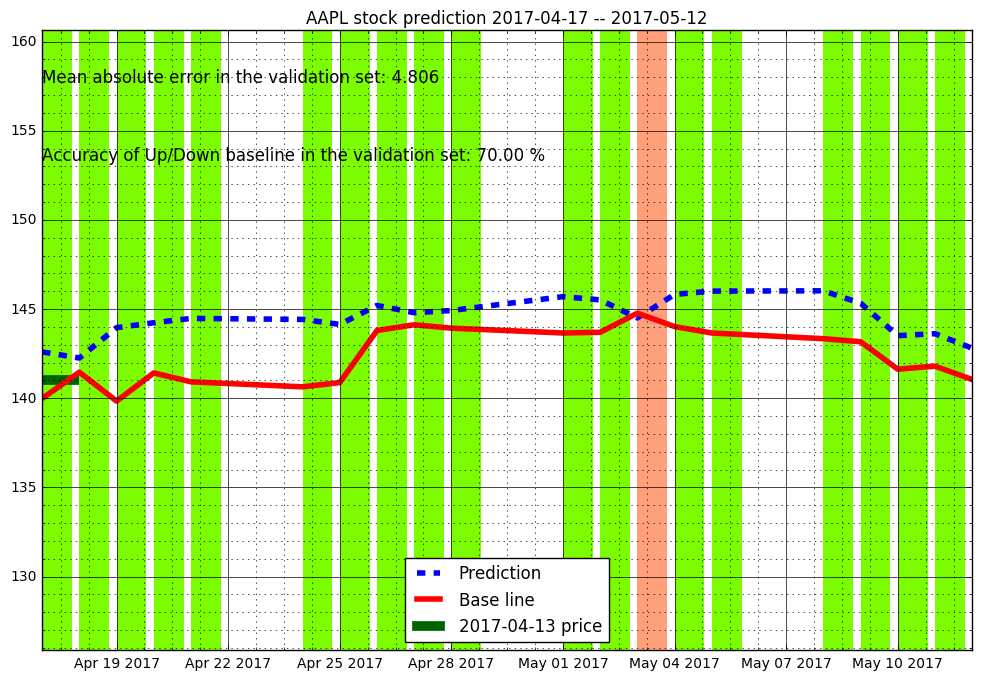

In [70]:
prediction_future_plot(x_train_std,x_test_std,  y_train,x_test,best_param, ['2017-04-14'], \
                       combined_data,window, mae_validation, Accuracy_validation, company)

<div style="text-align:justify"><span style="color:black; font-family:Times New Roman; font-size:1.5em;line-height:1.4em;"> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; For future stock prediction, the history data starting from 2011-01-05 until today (2017-04-13) is used to train the SVR model. This figure shows the stock prediction for 20 business days after today 2017-04-13.  I print out the mean absolute error and accuracy in the validation set as reference. I display two predictions. One is to predict the future price value marked by the blue dash line. The other is to predict whether the future price will be higher or lower than the base line. A green (pink) bar implies that the future price will be higher (lower) than the base line. Today’s price marked by the dark green line is also shown in the figure. Based on the predictions, the future price in one month has great opportunity to be higher than Today’s price. 
    
 </span></div>